# 🔬 Geneformer Series Showdown 🚀  
### 📊 Zero-Shot Scaling on SciPlex 2 Drug Perturbations  

Welcome to an exploration of the **Geneformer** model series, where we evaluate how model scaling influences performance on the **SciPlex 2** drug perturbation dataset — all in a **zero-shot** setting.  

This notebook dives into:  
- 🧠 How different Geneformer model sizes perform  
- 💥 Zero-shot inference on high-dimensional drug response data  
- 📈 Insights into biological signal capture vs. model scale  

Let’s see how far scaling takes us! 🧬

### Imports ⇅

In [1]:
import warnings
warnings.filterwarnings("ignore")

from helical.models.geneformer import Geneformer, GeneformerConfig
import anndata
import os
import urllib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import umap.umap_ as umap
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import RidgeClassifier

INFO:datasets:PyTorch version 2.6.0 available.


# Download the dataset

In [2]:
url = "https://zenodo.org/record/10044268/files/SrivatsanTrapnell2020_sciplex2.h5ad?download=1"
output_path = "SrivatsanTrapnell2020_sciplex2.h5ad"

if not os.path.exists(output_path):
    urllib.request.urlretrieve(url, output_path)
    print(f"Downloaded to {output_path}")
else:
    print(f"File already exists: {output_path}")

sciplex2_adata = anndata.read_h5ad(output_path)

File already exists: SrivatsanTrapnell2020_sciplex2.h5ad


## 🧬 Extracting Geneformer Embeddings  
### 🔧 Selected Models for Zero-Shot Evaluation

To evaluate how model scaling impacts representation quality, we extract embeddings from the following **Geneformer** model variants:

| Model Name             | Layers | Parameters | Input Dim |
|------------------------|--------|------------|-----------|
| `gf-6L-10M-i2048`      | 6      | 30M        | 2048      |
| `gf-12L-38M-i4096`     | 12     | 95M        | 4096      |
| `gf-12L-104M-i4096`    | 12     | 104M       | 4096      |
| `gf-18L-316M-i4096`    | 18     | 316M       | 4096      |

We evaluate each of these in their `cell` embedding mode which aggregates all gene level embeddings.

📥 Below, we generate embeddings for the SciPlex 2 perturbation data in a **zero-shot** setting.


In [3]:
if not os.path.exists("embeddings_6l_10m.npz"):
    gf_6l_30m_model = Geneformer(GeneformerConfig(model_name="gf-6L-10M-i2048", device="cuda", batch_size=8))

    num = gf_6l_30m_model.model.num_parameters(only_trainable=False)
    print(f"Number of parameters: {num:_}".replace("_", " "))
    
    print("Processing data and generating embeddings...")
    dataset = gf_6l_30m_model.process_data(sciplex2_adata)
    embeddings = gf_6l_30m_model.get_embeddings(dataset)

    with open("embeddings_6l_10m.npz", "wb") as f:
        np.save(f, embeddings)
else:
    print("Embeddings for 6L-10M model already exist. Skipping processing.")

Embeddings for 6L-10M model already exist. Skipping processing.


In [4]:
if not os.path.exists("embeddings_12l_38m.npz"):
    gf_12l_95m_model = Geneformer(GeneformerConfig(model_name="gf-12L-38M-i4096", device="cuda", batch_size=8))

    num = gf_12l_95m_model.model.num_parameters(only_trainable=False)
    print(f"Number of parameters: {num:_}".replace("_", " "))
    
    print("Processing data and generating embeddings...")
    dataset = gf_12l_95m_model.process_data(sciplex2_adata)
    embeddings = gf_12l_95m_model.get_embeddings(dataset)

    with open("embeddings_12l_38m.npz", "wb") as f:
        np.save(f, embeddings)
else:
    print("Embeddings for 12L-38M model already exist. Skipping processing.")

Embeddings for 12L-38M model already exist. Skipping processing.


In [5]:
if not os.path.exists("embeddings_12l_104m.npz"):
    gf_12l_104m_model = Geneformer(GeneformerConfig(model_name="gf-12L-104M-i4096", device="cuda", batch_size=1))

    num = gf_12l_104m_model.model.num_parameters(only_trainable=False)
    print(f"Number of parameters: {num:_}".replace("_", " "))
    
    print("Processing data and generating embeddings...")
    dataset = gf_12l_104m_model.process_data(sciplex2_adata)
    embeddings = gf_12l_104m_model.get_embeddings(dataset)

    with open("embeddings_12l_104m.npz", "wb") as f:
        np.save(f, embeddings)
else:
    print("Embeddings for 12L-104M model already exist. Skipping processing.")

Embeddings for 12L-104M model already exist. Skipping processing.


In [6]:
if not os.path.exists("embeddings_18l_316m.npz"):
    gf_18l_316m_model = Geneformer(GeneformerConfig(model_name="gf-18L-316M-i4096", device="cuda", batch_size=8))

    num = gf_18l_316m_model.model.num_parameters(only_trainable=False)
    print(f"Number of parameters: {num:_}".replace("_", " "))

    print("Processing data and generating embeddings...")
    dataset = gf_18l_316m_model.process_data(sciplex2_adata)
    embeddings = gf_18l_316m_model.get_embeddings(dataset)

    with open("embeddings_18l_316m.npz", "wb") as f:
        np.save(f, embeddings)
else:
    print("Embeddings for 18L-316M model already exist. Skipping processing.")

Embeddings for 18L-316M model already exist. Skipping processing.


## 🌌 Visualizing Geneformer Embeddings with UMAP  
### 🧭 How Do Different Model Scales Separate Drug Perturbations?

We use **UMAP** to project high-dimensional embeddings into 2D space for visual comparison across model scales. Each point represents a cell, colored by its **perturbation label** from the SciPlex 2 dataset.

🔍 Models visualized:
- **6L 10M**
- **12L 38M**
- **12L 104M**
- **18L 316M**

This visualization helps reveal how well each model separates different perturbation classes in a zero-shot setting — giving us insight into **representation quality** and **semantic clustering** as model capacity increases.

🎨 Legend shows unique perturbation labels encoded with consistent colors.

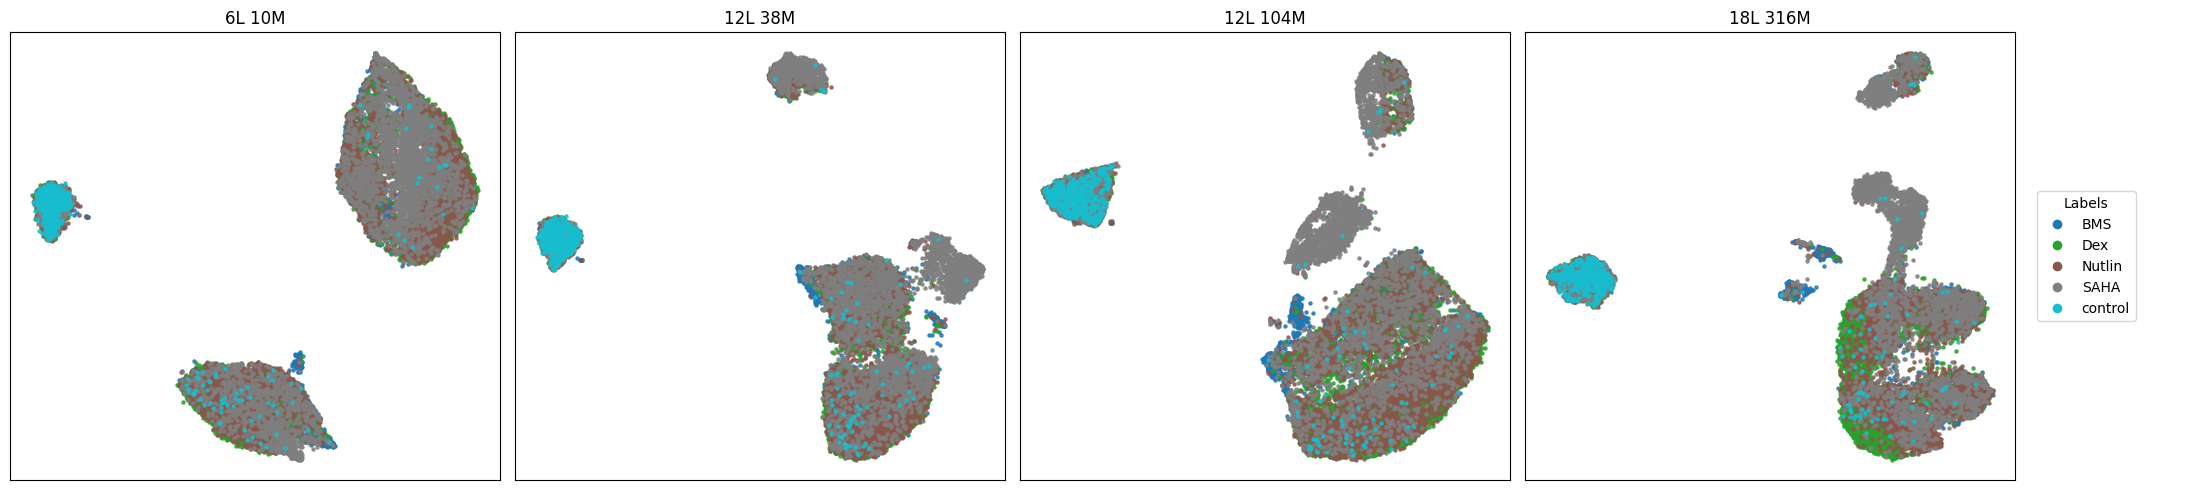

In [7]:
embeddings_list = [
    np.load("embeddings_6l_10m.npz"),
    np.load("embeddings_12l_38m.npz"),
    np.load("embeddings_12l_104m.npz"),
    np.load("embeddings_18l_316m.npz"),
]

labels = sciplex2_adata.obs["perturbation"].values
titles = ["6L 10M", "12L 38M", "12L 104M", "18L 316M"]

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
unique_labels = label_encoder.classes_
n_classes = len(unique_labels)

cmap = cm.get_cmap('tab10', n_classes)
colors = [cmap(i) for i in range(n_classes)]

fig = plt.figure(figsize=(22, 5))
gs = gridspec.GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 0.3])

reducer = umap.UMAP(random_state=42)

for i, (embeddings, title) in enumerate(zip(embeddings_list, titles)):
    ax = fig.add_subplot(gs[i])
    umap_result = reducer.fit_transform(embeddings)
    for class_idx in range(n_classes):
        ax.scatter(
            umap_result[labels_encoded == class_idx, 0],
            umap_result[labels_encoded == class_idx, 1],
            s=5, color=colors[class_idx], label=unique_labels[class_idx], alpha=0.8
        )
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

ax_legend = fig.add_subplot(gs[4])
ax_legend.axis('off')
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=colors[i], markersize=8,
                      label=unique_labels[i]) for i in range(n_classes)]
ax_legend.legend(handles=handles, loc='center left', fontsize=10, title="Labels")

plt.tight_layout()
plt.show()

## 🧪 Zero-Shot Classification with RidgeClassifier  
### 🧠 How Well Do Geneformer Embeddings Support Supervised Tasks?

To assess the **semantic quality** of embeddings across model scales, we train a simple **RidgeClassifier** on top of each embedding set to predict **perturbation labels**. This lightweight classifier helps us understand how **linearly separable** the embeddings are — a useful proxy for their expressive power.

🧰 **Evaluation Setup:**
- Train/test split: 80/20  
- Classifier: `RidgeClassifier` (no hyperparameter tuning)  
- Metrics: `Accuracy` and `F1 Score (weighted)`  

📊 **Results:**

| Model        | Accuracy | F1 Score |
|--------------|----------|----------|
| GF 6L 10M    | 0.658    | 0.642    |
| GF 12L 38M   | 0.698    | 0.685    |
| GF 12L 104M  | 0.724    | 0.712    |
| GF 18L 316M  | 0.726    | 0.716    |

📈 Below, we visualize these results to compare performance across models — showing a clear trend: **larger Geneformer models produce more discriminative embeddings** in this zero-shot drug perturbation setting.


         Model  Accuracy  F1 Score
0    GF 6L 10M  0.658150  0.642452
1   GF 12L 38M  0.697713  0.685367
2  GF 12L 104M  0.724294  0.712239
3  GF 18L 316M  0.726355  0.715880


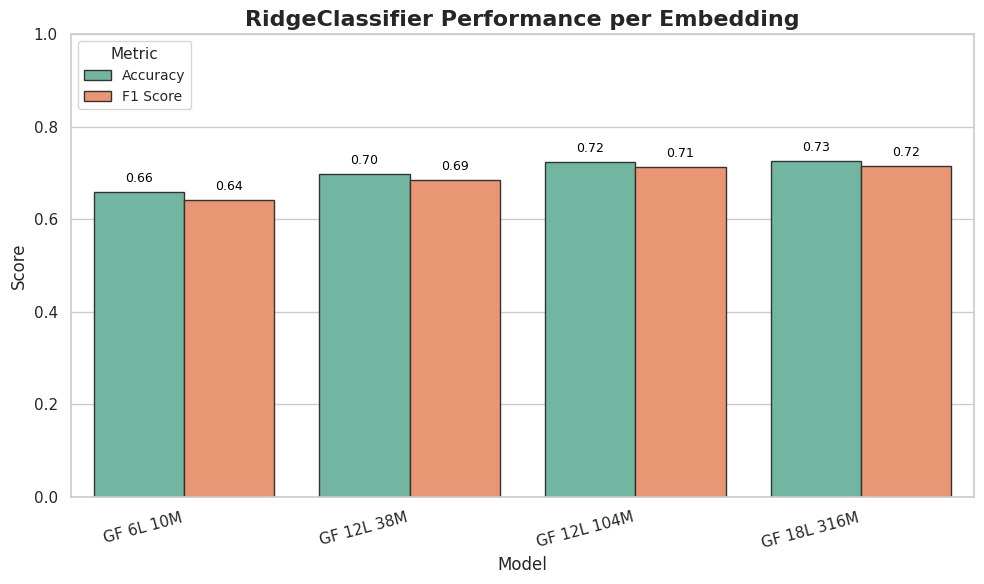

In [9]:
embedding_sets = [
    ("GF 6L 10M", embeddings_list[0]),
    ("GF 12L 38M", embeddings_list[1]),
    ("GF 12L 104M", embeddings_list[2]),
    ("GF 18L 316M", embeddings_list[3]),
]

results = []

for name, embeddings in embedding_sets:
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, sciplex2_adata.obs["perturbation"].values,
        test_size=0.2, random_state=42
    )
    clf = RidgeClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "F1 Score": f1
    })

# Convert to DataFrame for table display
results_df = pd.DataFrame(results)
print(results_df)

plot_df = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
palette = sns.color_palette("Set2", n_colors=2)

bar_plot = sns.barplot(
    data=plot_df,
    x="Model",
    y="Score",
    hue="Metric",
    palette=palette,
    edgecolor="0.2"
)

bar_plot.set_title("RidgeClassifier Performance per Embedding", fontsize=16, weight="bold")
bar_plot.set_ylabel("Score", fontsize=12)
bar_plot.set_xlabel("Model", fontsize=12)
bar_plot.set_ylim(0, 1.0)
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=15, ha='right')

bar_plot.legend(title="Metric", loc="upper left", fontsize=10, title_fontsize=11)

for p in bar_plot.patches:
    height = p.get_height()
    if height > 0.01:
        bar_plot.annotate(
            f'{height:.2f}',
            (p.get_x() + p.get_width() / 2., height),
            ha='center', va='bottom',
            fontsize=9, color='black',
            xytext=(0, 5), textcoords='offset points'
        )

plt.tight_layout()
plt.show()